# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import torch
from collections import deque
import datetime;

import json
config = json.load(open('config.json'))
train = False

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe",no_graphics=train, seed = config['SEED']['environment'])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=train)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -7.8029089  -1.5
 -0.          0.         -6.53731155  6.         -0.          0.        ]


In [5]:
from agent_ddpg import Agent
agents = []
print(json.dumps(config, indent=4))
agents.append(Agent(state_size, action_size, config['SEED']['agent']))
agents.append(Agent(state_size, action_size, config['SEED']['agent']))
print(agents[0].actor_local)
print(agents[0].critic_local)

{
    "TAU": 0.001,
    "LR_CRITIC": 0.0001,
    "LR_ACTOR": 0.0001,
    "GAMMA": 0.99,
    "BUFFER_SIZE": 400000,
    "BATCH_SIZE": 256,
    "WEIGHT_DECAY": 0.0,
    "noise": {
        "sigma": 0.01,
        "mu": 0.0,
        "theta": 0.15
    },
    "SEED": {
        "environment": 10,
        "agent": 42
    },
    "model": {
        "actor": [
            {
                "type": "Linear",
                "size": 8,
                "activation": "RELU"
            },
            {
                "type": "batchnormalization"
            },
            {
                "type": "Linear",
                "size": 64,
                "activation": "RELU"
            },
            {
                "type": "Linear",
                "size": 64,
                "activation": "RELU"
            },
            {
                "type": "Linear",
                "size": 4
            }
        ],
        "critic": [
            {
                "type": "Linear",
                "size": 8

In [6]:
episodes = 1500
expected_score = 0.5
scores = []
scores_window = deque(maxlen=100)
avg_scores = []
solved_episode = -1
game_length_window =deque(maxlen=100)
game_length = []
avg_game_length = []
network_loss = []
for episode in range(1, episodes+1):                                    # play game for n episodes
    start = datetime.datetime.now()
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    ep_scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    count = 0
    [agent.reset() for agent in agents]
    while True:        
        count += 1
        actions = [agents[i].act(states[i], True) for i in range(num_agents)] # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        ep_scores += env_info.rewards                         # update the score (for each agent)
        
        [agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i]) for i in range(num_agents)]
        
        [network_loss.append(agent.step_learn()) for agent in agents]
        
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    #print(ep_scores)
    
    took = datetime.datetime.now() -start    
    ep_score = np.max(ep_scores)
    scores.append(ep_score)
    scores_window.append(ep_score)
    avg_score = np.mean(scores_window)
    avg_scores.append(avg_score)    
    game_length.append(count)
    game_length_window.append(count)
    avg_game_length.append(np.mean(game_length_window))
    print('Score (max over agents) from episode\t{}:\t{:.5f}\tAverage Score:\t{:.5f}\ttime:\t{:s}\tactions:\t{}'.format(episode, ep_score, avg_score, str(took), count))
    if (solved_episode < 0 and avg_score >= expected_score):
        print('Solved in episode '+ episode)
        solved_episode = episode
        for i in range(num_agents):
            torch.save(agent.actor_local.state_dict(), 'solved_{:d}_actor_local.pth'.format(episode))
            torch.save(agent.critic_local.state_dict(), 'solved_{:d}_critic_local.pth'.format(episode))

print('Solved in episode {}'.format(solved_episode))
for i in range(num_agents):
    torch.save(agents[i].actor_local.state_dict(), 'end_actor{}_local.pth'.format(i))
    torch.save(agents[i].critic_local.state_dict(), 'end_critic{}_local.pth'.format(i))

ValueError: Format specifier missing precision

When finished, you can close the environment.

In [ ]:
env.close()

In [ ]:
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(avg_scores)), avg_scores)
#plt.plot(np.arange(len(scores)), expected_score*np.ones(len(scores)))
plt.xlabel('Episode number')
plt.ylabel('Score')
plt.show()
plt.savefig('graph_trained_{:d}_episodes.png'.format(len(scores)))

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(game_length)), game_length)
plt.plot(np.arange(len(avg_game_length)), avg_game_length)
#plt.plot(np.arange(len(scores)), expected_score*np.ones(len(scores)))
plt.xlabel('Episode number')
plt.ylabel('Turns')
plt.show()
plt.savefig('graph_gamelength_{:d}_episodes.png'.format(len(game_length)))

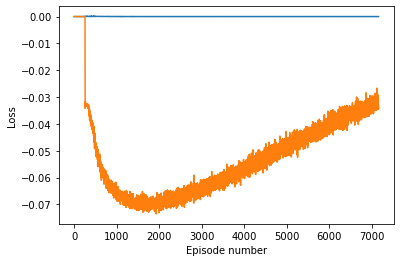

<Figure size 432x288 with 0 Axes>

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(network_loss)), network_loss)
#plt.plot(np.arange(len(scores)), expected_score*np.ones(len(scores)))
plt.xlabel('Episode number')
plt.ylabel('Loss')
plt.show()
plt.savefig('graph_loss_{:d}_episodes.png'.format(len(network_loss)))